In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

In [2]:
#Import data from file saved on system
Infy = pd.read_csv('Infy-His-data2018-20.csv')
print (Infy.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2018-01-01  518.849976  522.250000  515.000000  516.775024  474.472595   
1  2018-01-02  518.625000  521.000000  511.500000  514.849976  472.705139   
2  2018-01-03  514.250000  515.799988  509.299988  510.649994  468.848938   
3  2018-01-04  510.500000  510.500000  504.799988  507.700012  466.140472   
4  2018-01-05  507.649994  513.200012  503.000000  506.000000  464.579559   

     Volume  
0   5431340  
1   6112248  
2   6846552  
3   8947614  
4  11025976  


In [11]:
T = pd.DataFrame({"Date": Infy["Date"], "Close": Infy["Close"]})
SMA=10
LMA=30

# Compute Moving averages of last 10 days and 30 days closing prices
T['Short_average'] = T['Close'].rolling(window=SMA, min_periods=1, center=False).mean()
T['Long_average'] = T['Close'].rolling(window=LMA, min_periods=1, center=False).mean()

T['positions_long'] = np.nan

for x in range (len(T)):
    if T.Short_average[x] > T.Long_average[x]:
        T['positions_long'][x] = 1
    if T.Short_average[x] <= T.Long_average[x]:
        T['positions_long'][x] = 0

T.positions_long = T.positions_long.fillna(method='ffill')  

T['price_difference']= T.Close - T.Close.shift(1)
T['pnllong'] = T.positions_long.shift(1) * T.price_difference
T['cumpnl_long'] = T.pnllong.cumsum()

print(T)

           Date        Close  Short_average  Long_average  positions_long  \
0    2018-01-01   516.775024     516.775024    516.775024             0.0   
1    2018-01-02   514.849976     515.812500    515.812500             0.0   
2    2018-01-03   510.649994     514.091665    514.091665             0.0   
3    2018-01-04   507.700012     512.493752    512.493752             0.0   
4    2018-01-05   506.000000     511.195001    511.195001             0.0   
..          ...          ...            ...           ...             ...   
732  2020-12-23  1253.050049    1181.565002   1144.204997             1.0   
733  2020-12-24  1236.050049    1188.395007   1149.038330             1.0   
734  2020-12-28  1240.300049    1196.105017   1152.964998             1.0   
735  2020-12-29  1250.300049    1204.680017   1157.383333             1.0   
736  2020-12-30  1246.800049    1213.900024   1161.470003             1.0   

     price_difference    pnllong  cumpnl_long  
0                 NaN      

<ipython-input-11-4138d35e5fce>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T['positions_long'][x] = 0
<ipython-input-11-4138d35e5fce>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T['positions_long'][x] = 1


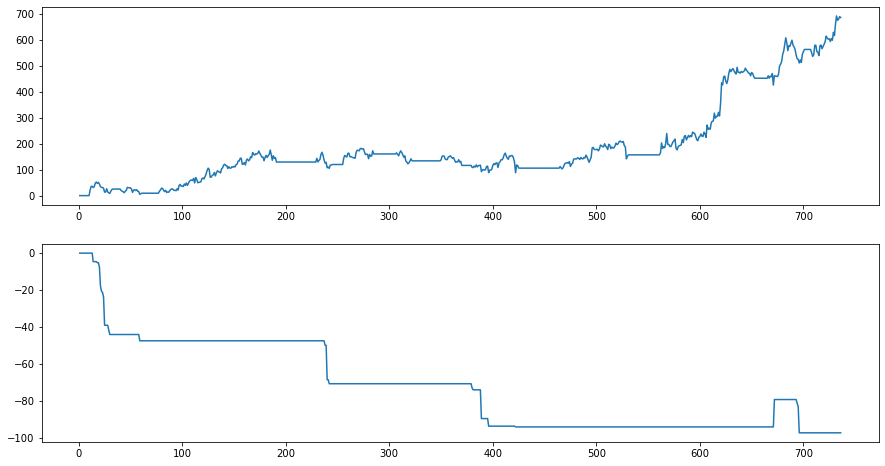

In [12]:
# Calculate the max drawdown in the past window days for each day 
T['rolling_max'] = T['cumpnl_long'].rolling(250, min_periods=1).max()
T['daily_drawdown'] = T['cumpnl_long']-T['rolling_max']

# Calculate the minimum (negative) daily drawdown
T['max_daily_drawdown'] = T['daily_drawdown'].rolling(250, min_periods=1).min()

fig, axs = plt.subplots(2,figsize=(15,8))
axs[0].plot(T['cumpnl_long'])
axs[1].plot(T['max_daily_drawdown'])


In [13]:
T['Trade'] = T['positions_long'].diff()
T2 = T.where((T.Trade != 0)) 
T2 = T2.dropna()
T2.drop(["positions_long", "Short_average", "Long_average", "price_difference", "pnllong", "rolling_max", "daily_drawdown", "max_daily_drawdown"], axis = 1, inplace = True)
T2['Trade_Return'] = (T2['cumpnl_long'].diff()/T2['Close'])*100
print ("Number of Trade count", round(len(T2)/2))
print (T2)

Number of Trade count 12
           Date        Close  cumpnl_long  Trade  Trade_Return
10   2018-01-15   540.575012     0.000000    1.0           NaN
33   2018-02-19   565.875000    25.299988   -1.0      4.470950
40   2018-02-28   586.299988    25.299988    1.0      0.000000
61   2018-04-03   570.224976     9.224976   -1.0     -2.819065
77   2018-04-25   580.174988     9.224976    1.0      0.000000
191  2018-10-10   700.450012   129.500000   -1.0     17.171107
229  2018-12-06   668.500000   129.500000    1.0      0.000000
245  2018-12-31   658.950012   119.950012   -1.0     -1.449273
255  2019-01-14   701.900024   119.950012    1.0      0.000000
285  2019-02-26   742.500000   160.549988   -1.0      5.468010
306  2019-04-01   755.099976   160.549988    1.0      0.000000
322  2019-04-25   728.549988   134.000000   -1.0     -3.644223
349  2019-06-06   735.599976   134.000000    1.0      0.000000
370  2019-07-05   718.000000   116.400024   -1.0     -2.451250
379  2019-07-18   792.700012  

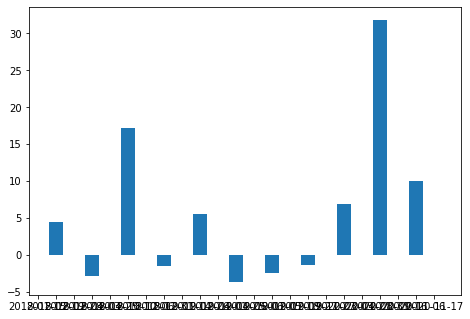

In [14]:
# Plot trade retruns
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(T2['Date'], T2['Trade_Return'])
plt.show()